## Train an LSTM Model for Next Day Prediction Using Extracted Features

In [1]:
! pip install -U -q "neptune[tensorflow-keras]" tensorflow ta

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.4/501.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.8 MB/s eta 0:00:00


In [2]:
import neptune
import logging
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import matplotlib.patches as patches
import matplotlib.patches as mpatches

from tqdm.notebook import tqdm  # Use notebook version of tqdm for better compatibility with Jupyter
from ta.momentum import RSIIndicator
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy.optimize import minimize

In [3]:
# Disable specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="accelerate")
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")
warnings.filterwarnings("ignore", module="sklearn.metrics._classification")
neptune_logger = logging.getLogger('neptune')
neptune_logger.setLevel(logging.ERROR)

In [4]:
plt.style.use('default')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Neptune Init

In [100]:
# Define the Neptune initialization function (assuming it's in your code)
def init_neptune_run(name, description, params, tags, notebook_addr='/content/drive/MyDrive//LSTM_Predictor.ipynb'):
    """
    Initializes and returns an instance of a Neptune run and sends the parameters
    """
    run = neptune.init_run(
        project='Financial-NLP/LSTM-Predictor',
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlYTFiMTEwZS0zY2Q5LTQ3MGItODZjZS0zMTcwM2RjMzZmNjAifQ==",
        name=name,
        tags=tags,
        description=description
    )

    run["notebook"].upload(notebook_addr)
    run["parameters"] = params
    return run

# Parameters for the Neptune run
params = {
    "model_type": "LSTM",
    "layers": [
        {"LSTM": 128, "return_sequences": True},
        {"Dropout": 0.2},
        {"LSTM": 64, "return_sequences": False},
        {"Dropout": 0.2},
        {"Dense": 32, "activation": "relu", "kernel_regularizer": "l2(0.001)"},
        {"Dense": 3, "activation": "softmax"},
    ],
    "optimizer": "Adam",
    "learning_rate": 0.002,
    "epochs": 100,
    "batch_size": 64,
}

# Initialize Neptune run
run = init_neptune_run(
    name="LSTM Model Training Using a more complicated model.",
    description="Training an LSTM model for multi-class classification with augmented dataset",
    params=params,
    tags=["LSTM", "training", "classification"]
)

### Load the price data

In [8]:
# db_path = '../raw/daily-2020.csv'

# db_path = '/content/drive/MyDrive/daily-2020.csv'
# price_df = pd.read_csv(db_path, usecols=["timestamp", "close", "open", "high", "low", "volume"])
# price_df.set_index('timestamp', inplace=True)
# price_df.index = pd.to_datetime(price_df.index, unit='s')

In [9]:
# impact_ratio_path = '/content/drive/MyDrive/impact_ratios.csv'
impact_ratio_path = '/content/drive/MyDrive/mean_impact_ratio.csv'
impact_ratio = pd.read_csv(impact_ratio_path)
impact_ratio = impact_ratio.rename(columns={'date': 'timestamp'})
impact_ratio.set_index('timestamp', inplace=True)
impact_ratio = impact_ratio.sort_index()
impact_ratio

,impact_label
timestamp,
2015-02-08,1.000000
2015-02-09,1.000000
2015-02-10,1.000000
2015-02-11,1.000000
2015-02-12,1.000000
...,...
2021-02-11,1.004587
2021-02-12,0.990950
2021-02-13,0.975962


In [10]:
ratio_feat = pd.read_csv('/content/drive/MyDrive/ratio_2015_2021.csv')

# Reverse the order of the rows in the ratio_feat DataFrame
ratio_feat = ratio_feat.sort_values(by='timestamp').reset_index(drop=True)
ratio_feat.set_index('timestamp', inplace=True)
ratio_feat = ratio_feat.sort_index()
ratio_feat

,ratio,close
timestamp,,
2015-01-01,1.782609,314.136000
2015-01-02,0.975000,315.207000
2015-01-03,0.250000,284.234000
2015-01-04,0.568627,264.201000
2015-01-05,0.290909,274.570000
...,...,...
2021-02-11,1.319149,47680.424438
2021-02-12,1.351064,47622.568921
2021-02-13,1.390805,47056.769565


In [11]:
# Define the ticker for Bitcoin (BTC-USD is the ticker for Bitcoin in US Dollars on Yahoo Finance)
ticker = "BTC-USD"

# Define the start and end dates
start_date = "2015-01-01"
end_date = "2021-02-16"

# Fetch the historical data from Yahoo Finance
btc_data = yf.download(ticker, start=start_date, end=end_date)

# Keep only the required columns and reset the index to have a column 'timestamp'
btc_data = btc_data[["Open", "High", "Low", "Close", "Volume"]]
btc_data.reset_index(inplace=True)
btc_data.rename(columns={"Date": "timestamp", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"}, inplace=True)
btc_data.set_index('timestamp', inplace=True)

# Display the first few rows of the data
btc_data.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
timestamp,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800


In [12]:
# Create a complete date range from 2015-01-01 to 2021-02-15
full_date_range = pd.date_range(start="2015-01-01", end="2021-02-15")

# Find missing dates in ratio_feat compared to the full_date_range
missing_dates_in_ratio_feat = full_date_range.difference(ratio_feat.index)

# Convert the missing dates to a DataFrame (if needed)
missing_dates_df = pd.DataFrame(missing_dates_in_ratio_feat, columns=['timestamp'])

# Print missing dates
print("Missing dates in ratio_feat:")
missing_dates_df

Missing dates in ratio_feat:


,timestamp
0,2015-12-31
1,2016-08-07
2,2016-12-31
3,2017-03-27
4,2017-12-31
...,...
92,2019-03-27
93,2019-03-28
94,2019-03-29
95,2019-03-30


In [13]:
# Convert the 'timestamp' column of missing_dates_df to a list for easy removal
missing_dates = missing_dates_df['timestamp'].tolist()

# Step 1: Remove rows from btc_data with missing timestamps
btc_data_cleaned = btc_data.drop(index=missing_dates, errors='ignore')
len(btc_data_cleaned)

2141

In [14]:
# Convert indices to datetime if they are not already
btc_data_cleaned.index = pd.to_datetime(btc_data_cleaned.index)
ratio_feat.index = pd.to_datetime(ratio_feat.index)

# Ensure both indices are sorted
btc_data_cleaned.sort_index(inplace=True)
ratio_feat.sort_index(inplace=True)

# Check if indices are equal
if not btc_data_cleaned.index.equals(ratio_feat.index):
    print("Indices do not match. Please check the indices of both DataFrames.")
else:
    # Assign the 'ratio' column from ratio_feat to btc_data_cleaned
    btc_data_cleaned['sentiment_ratio'] = ratio_feat['ratio']

    # Check the updated btc_data_cleaned
    btc_data_cleaned.head()

In [15]:
if btc_data_cleaned['sentiment_ratio'].equals(ratio_feat['ratio']):
  print('all equal!')
else:
  print('not equal')

all equal!


In [16]:
# Find missing dates in impact_ratio compared to the btc_data_cleaned
missing_dates_in_impact = btc_data_cleaned.index.difference(impact_ratio.index)

# Convert the missing dates to a DataFrame (if needed)
missing_dates_df = pd.DataFrame(missing_dates_in_impact, columns=['timestamp'])

# Print missing dates
print("Missing dates in impact_ratio:")
missing_dates_df

Missing dates in impact_ratio:


,timestamp
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
5,2015-01-06
6,2015-01-07
7,2015-01-08
8,2015-01-09
9,2015-01-10


In [17]:
# Convert the 'timestamp' column of missing_dates_df to a list for easy removal
missing_dates = missing_dates_df['timestamp'].tolist()

# Remove rows from btc_data with missing timestamps
btc_data_cleaned = btc_data_cleaned.drop(index=missing_dates, errors='ignore')
len(btc_data_cleaned)

2103

In [18]:
len(btc_data_cleaned.index), len(impact_ratio.index)

(2103, 2104)

In [19]:
# Convert indices to datetime if they are not already
btc_data_cleaned.index = pd.to_datetime(btc_data_cleaned.index)
impact_ratio.index = pd.to_datetime(impact_ratio.index)

# Find missing dates in impact_ratio compared to the btc_data_cleaned
missing_dates_in_impact = impact_ratio.index.difference(btc_data_cleaned.index)

# Convert the missing dates to a DataFrame (if needed)
missing_dates_df = pd.DataFrame(missing_dates_in_impact, columns=['timestamp'])

# Print missing dates
print("Missing dates in btc:")
missing_dates_df

Missing dates in btc:


,timestamp
0,2017-03-27


In [20]:
# Convert the 'timestamp' column of missing_dates_df to a list for easy removal
missing_dates = missing_dates_df['timestamp'].tolist()

# Remove rows from btc_data with missing timestamps
impact_ratio = impact_ratio.drop(index=missing_dates, errors='ignore')
len(impact_ratio)

2103

In [21]:
# Convert indices to datetime if they are not already
btc_data_cleaned.index = pd.to_datetime(btc_data_cleaned.index)
impact_ratio.index = pd.to_datetime(impact_ratio.index)

# Ensure both indices are sorted
btc_data_cleaned.sort_index(inplace=True)
impact_ratio.sort_index(inplace=True)

# Check if indices are equal
if not btc_data_cleaned.index.equals(impact_ratio.index):
    print("Indices do not match. Please check the indices of both DataFrames.")
else:
    # Assign the 'ratio' column from ratio_feat to btc_data_cleaned
    btc_data_cleaned['impact_ratio'] = impact_ratio['impact_label']

    # Check the updated btc_data_cleaned
    btc_data_cleaned.head()

In [22]:
if btc_data_cleaned['impact_ratio'].equals(impact_ratio['impact_label']):
  print('all equal!')
else:
  print('not equal')

all equal!


In [23]:
btc_data_cleaned

,open,high,low,close,volume,sentiment_ratio,impact_ratio
timestamp,,,,,,,
2015-02-08,227.692993,229.438004,221.076996,223.412003,17145200,0.348485,1.000000
2015-02-09,223.389008,223.977005,217.018997,220.110001,27791300,0.425926,1.000000
2015-02-10,220.281998,221.807007,215.332001,219.839005,21115100,0.719298,1.000000
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1.000000
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1.000000
...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,0.975962


In [24]:
price_df = btc_data_cleaned
price_df

,open,high,low,close,volume,sentiment_ratio,impact_ratio
timestamp,,,,,,,
2015-02-08,227.692993,229.438004,221.076996,223.412003,17145200,0.348485,1.000000
2015-02-09,223.389008,223.977005,217.018997,220.110001,27791300,0.425926,1.000000
2015-02-10,220.281998,221.807007,215.332001,219.839005,21115100,0.719298,1.000000
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1.000000
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1.000000
...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,0.975962


### Volatility calculation and event extraction

In [25]:
def get_daily_vol(close, span0=100):
    """
    Calculate the daily volatility of closing prices.

    Parameters:
    - close: A pandas Series of closing prices.
    - span0: The span for the EWM standard deviation.

    Returns:
    - A pandas Series of daily volatility estimates.
    """
    # Find the start of the previous day for each day
    prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    prev_day_start = prev_day_start[prev_day_start > 0]

    # Create a series with the start of the previous day for each day
    prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

    # Calculate daily returns
    daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

    # Calculate EWM standard deviation of daily returns
    daily_vol = daily_returns.ewm(span=span0).std()

    return daily_returns, daily_vol

In [26]:
price_df["daily_returns"], price_df["volatility"] = get_daily_vol(price_df.close)

In [27]:
price_df.dropna(inplace=True)

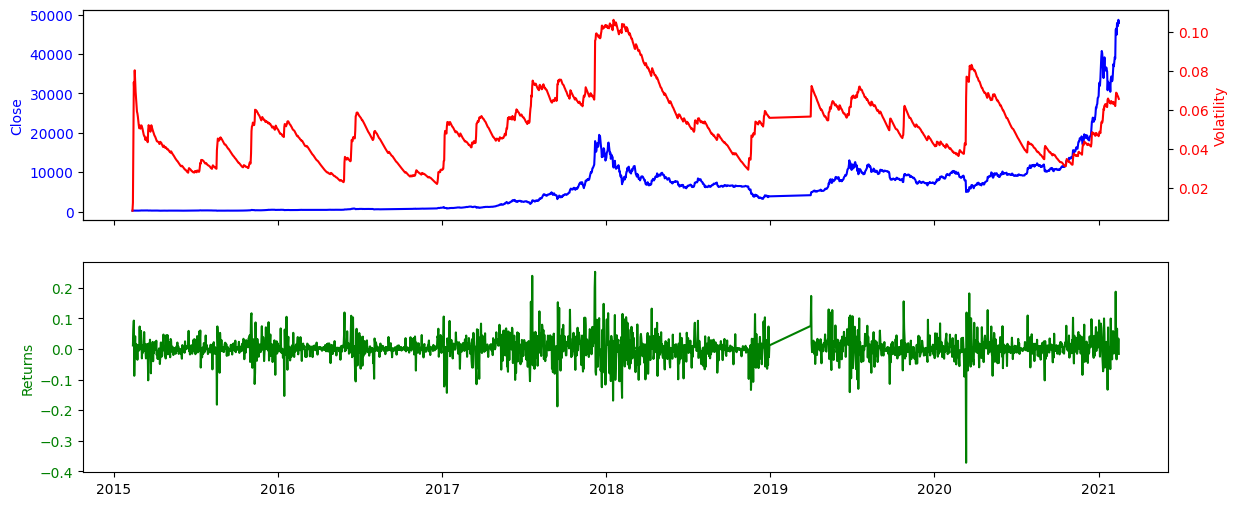

In [28]:
# Calculate returns
price_df['returns'] = price_df['close'].pct_change()

# Create a new figure with two subplots
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(14, 6))

# Plot 'close' on the primary y-axis of the first subplot
ax1.plot(price_df.index, price_df['close'], color='blue')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for 'volatility' on the first subplot
ax2 = ax1.twinx()
ax2.plot(price_df.index, price_df['volatility'], color='red')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot 'returns' on the second subplot
ax3.plot(price_df.index, price_df['returns'], color='green')
ax3.set_ylabel('Returns', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Show the plot
plt.show()

In [29]:
def get_t_events(raw_price, volatility, base_threshold):
    """
    :param raw_price: (series) of close prices.
    :param volatility: (series) of volatility values.
    :param base_threshold: (float) base level for the threshold.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events, s_pos, s_neg = [], 0, 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        # Adjust the threshold based on volatility
        threshold = base_threshold * volatility.loc[i]

        s_pos = max(0.0, float(s_pos + diff.loc[i]))
        s_neg = min(0.0, float(s_neg + diff.loc[i]))

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [30]:
events = get_t_events(price_df.close, price_df.volatility, 1.5)

Applying Symmetric CUSUM filter.


  0%|          | 0/2098 [00:00<?, ?it/s]

In [31]:
price_df["event"] = price_df.index.isin(events)

In [32]:
price_df

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,returns,event
timestamp,,,,,,,,,,,
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1.000000,-0.004202,0.008337,NaN,False
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1.000000,0.008756,0.012383,0.011766,False
2015-02-13,221.968994,240.259003,221.261993,235.427002,42744400,1.562500,1.000000,0.074102,0.040530,0.061611,False
2015-02-14,235.528000,259.808014,235.528000,257.321014,49732500,0.930233,1.000000,0.160337,0.074090,0.092997,True
2015-02-15,257.506989,265.610992,227.684006,234.824997,56552400,0.360000,1.000000,-0.002557,0.069003,-0.087424,False
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587,0.030727,0.067779,0.066591,False
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950,0.057586,0.067252,-0.008443,False
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,0.975962,-0.016778,0.066857,-0.008406,False


[neptune] [error  ] Error occurred during asynchronous operation processing: Cannot upload file /content/drive/MyDrive/LSTM_Predictor.ipynb: Path not found or is a not a file.


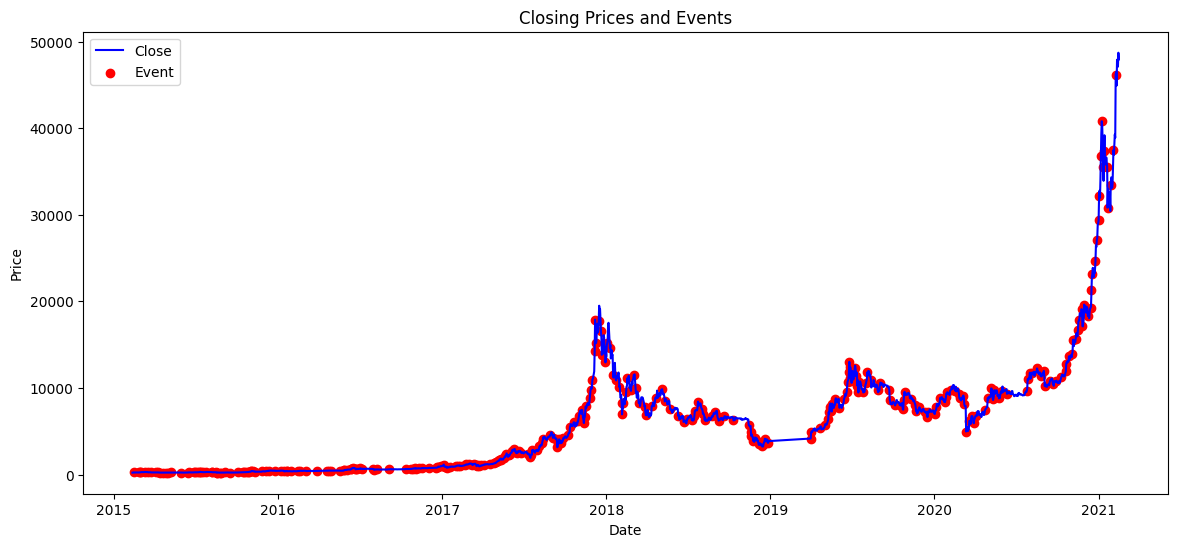

In [33]:
# Plot the closing prices
plt.subplots(figsize=(14, 6))
plt.plot(price_df.index, price_df['close'], color='blue', label='Close')

# Add dots for the event dates
plt.scatter(events, price_df.loc[events, 'close'], color='red', label='Event')

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Prices and Events')
plt.legend()

# Show the plot
plt.show()

### Triple Barrier Labeling

In [34]:
# Define labels as named constants for readability
LABEL_UP = 2
LABEL_DOWN = 0
LABEL_NEUTRAL = 1

In [35]:
def calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type='volatility'):
    end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

    # Calculate the mean volatility or daily returns over the volatility_period
    if barrier_type == 'volatility':
        mean_value = df.loc[i-volatility_period+1:i, 'volatility'].mean()
        current_value = df.loc[i, 'volatility']
    elif barrier_type == 'returns':
        mean_value = df.loc[i-volatility_period+1:i, 'daily_returns'].mean()
        current_value = df.loc[i, 'daily_returns']
    else:
        print(f'the barrier type: {barrier_type}')
        raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

    df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * upper_barrier_factor)
    df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * lower_barrier_factor)
    return df

In [36]:
def label_observations(df, origin, i, label):
    df.loc[origin:i+1, 'labels'] = label
    return df

In [37]:
def triple_barrier_labeling(sdf, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL"):
    df = sdf.copy()
    df = df.reset_index()

    # Initialize labels and window start
    df['labels'] = LABEL_NEUTRAL
    df['window_start'] = False

    window = vertical_barrier
    origin = 0
    touch_upper = lambda high, barrier: high >= barrier
    touch_lower = lambda low, barrier: low <= barrier
    # For each observation
    for i in range(0, len(df)):
        # Define your barriers at the beginning of each window
        if i == origin:
            df = calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type)
            df.loc[i, 'window_start'] = True  # Mark the start of the window

        # one of the conditions were met
        if touch_upper(df.loc[i, "high" if touch_type == 'HL' else 'close'], df.loc[i, "upper_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_UP)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier
        elif touch_lower(df.loc[i, "low" if touch_type == 'HL' else 'close'], df.loc[i, "lower_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_DOWN)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier

        # none of the conditions were met
        else:
            if window > 0:
                # reduce window size by one
                window = window - 1
            else:
                # reset window
                window = vertical_barrier
                # label neutral from origin to origin + window
                df.loc[origin:min(origin+window, len(df)-1), 'labels'] = LABEL_NEUTRAL  # Ensure the window does not exceed the dataframe
                # set origin to the next id
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index

    df = df.set_index("timestamp")
    return df

#### TBL Optimization to Find the Best Hyper-params

In [38]:
# Define the ranges manually to make sure for valid values
vol_periods = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

barrier_factors = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

# Define the expanded hyperparameter grid
param_grid = {
    'volatility_period': vol_periods,
    'upper_barrier_factor': barrier_factors,
    'lower_barrier_factor': barrier_factors,
    'vertical_barrier': vol_periods,
    'barrier_type': ['volatility', 'returns'],
    'touch_type': ['HL', 'C']
}

def buy_and_hold(price_series, labels, initial_capital=100000, commission_fee=0.001):
    """
    Simulates a buy-and-hold strategy based on the provided labels.
    Buys or sells according to the labels and calculates the resulting portfolio value.

    Parameters:
    - price_series: Series of price data.
    - labels: Series of trade signals (1 for buy, -1 for sell, 0 for hold).
    - initial_capital: Starting capital for the simulation.
    - commission_fee: Commission fee per trade (default is 0.1%).

    Returns:
    - portfolio_values: Series of portfolio values over time.
    """
    positions = 0  # Number of shares held
    capital = initial_capital  # Current capital
    portfolio_values = []

    for date, label in labels.items():
        price = price_series.loc[date]

        if label == 1:  # Buy
            shares_to_buy = capital // price
            cost = shares_to_buy * price
            commission = cost * commission_fee
            positions += shares_to_buy
            capital -= cost + commission
        elif label == -1:  # Sell
            revenue = positions * price
            commission = revenue * commission_fee
            capital += revenue - commission
            positions = 0

        portfolio_value = capital + positions * price
        portfolio_values.append(portfolio_value)

    return pd.Series(portfolio_values, index=labels.index)


def calculate_sharpe_ratio(portfolio_values):
    returns = portfolio_values.pct_change().dropna()

    # Annualized Sharpe Ratio for crypto market
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(365)
    return sharpe_ratio

def calculate_net_profit(portfolio_values, initial_capital=100000):
    net_profit = portfolio_values.iloc[-1] - initial_capital
    return net_profit

def sharpe_ratio_objective(params, price_df, initial_capital):
    volatility_period, upper_barrier_factor, lower_barrier_factor, vertical_barrier, barrier_type, touch_type = params

    labeled_df = triple_barrier_labeling(price_df,
                                         volatility_period=params[0],
                                         upper_barrier_factor=params[1],
                                         lower_barrier_factor=params[2],
                                         vertical_barrier=params[3],
                                         barrier_type=params[4],
                                         touch_type=params[5])
    labeled_df.set_index(price_df.index, inplace=True)

    portfolio_values = buy_and_hold(price_df['close'], labeled_df['labels'], initial_capital)
    return -calculate_sharpe_ratio(portfolio_values)  # We minimize the negative Sharpe Ratio to maximize the Sharpe Ratio

def tune_hyperparameters_scipy(price_df, param_grid, initial_capital=100000, num_starts=10):
    best_sharpe_ratio = -np.inf
    best_net_profit = -np.inf
    best_params = None

    param_space = [
        vol_periods,
        barrier_factors,
        barrier_factors,
        vol_periods,
        param_grid['barrier_type'],
        param_grid['touch_type']
    ]

    bounds = [
        (0, len(vol_periods) - 1),
        (0, len(barrier_factors) - 1),
        (0, len(barrier_factors) - 1),
        (0, len(vol_periods) - 1),
        (0, len(param_grid['barrier_type']) - 1),
        (0, len(param_grid['touch_type']) - 1)
    ]

    def bounds_to_params(x):
        return [
            vol_periods[int(x[0])],
            barrier_factors[int(x[1])],
            barrier_factors[int(x[2])],
            vol_periods[int(x[3])],
            param_grid['barrier_type'][int(x[4])],
            param_grid['touch_type'][int(x[5])]
        ]

    def objective_wrapper(x, price_df, initial_capital):
        params = bounds_to_params(x)
        return sharpe_ratio_objective(params, price_df, initial_capital)

    for _ in tqdm(range(num_starts), desc="Optimizing"):
        initial_params = [
            np.random.choice(param_space[0]),
            np.random.choice(param_space[1]),
            np.random.choice(param_space[2]),
            np.random.choice(param_space[3]),
            np.random.choice(param_space[4]),
            np.random.choice(param_space[5])
        ]

        initial_guess = [
            vol_periods.index(initial_params[0]),
            barrier_factors.index(initial_params[1]),
            barrier_factors.index(initial_params[2]),
            vol_periods.index(initial_params[3]),
            param_grid['barrier_type'].index(initial_params[4]),
            param_grid['touch_type'].index(initial_params[5])
        ]

        result = minimize(objective_wrapper, initial_guess, args=(price_df, initial_capital), method='SLSQP', bounds=bounds)

        if result.success:
            optimal_params = bounds_to_params(result.x)
            current_sharpe_ratio = -result.fun

            if current_sharpe_ratio > best_sharpe_ratio:
                best_sharpe_ratio = current_sharpe_ratio
                labeled_df = triple_barrier_labeling(price_df,
                                                     volatility_period=optimal_params[0],
                                                     upper_barrier_factor=optimal_params[1],
                                                     lower_barrier_factor=optimal_params[2],
                                                     vertical_barrier=optimal_params[3],
                                                     barrier_type=optimal_params[4],
                                                     touch_type=optimal_params[5])
                labeled_df.set_index(price_df.index, inplace=True)
                portfolio_values = buy_and_hold(price_df['close'], labeled_df['labels'], initial_capital)
                best_net_profit = portfolio_values.iloc[-1] - initial_capital
                best_params = optimal_params

    return best_params, best_sharpe_ratio, best_net_profit

In [39]:
# Example usage
best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters_scipy(price_df, param_grid)
print(f"Best Params: {best_params}, Best Sharpe Ratio: {best_sharpe_ratio}, Best Net Profit: {best_net_profit}")

Optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

Best Params: [10, 1.9, 2.0, 15, 'returns', 'HL'], Best Sharpe Ratio: 1.6355248814349246, Best Net Profit: 20852004.318922117


In [40]:
best_params

[10, 1.9, 2.0, 15, 'returns', 'HL']

In [41]:
tbl_df = triple_barrier_labeling(price_df, volatility_period=best_params[0], upper_barrier_factor=best_params[1], lower_barrier_factor=best_params[2], vertical_barrier=best_params[3], min_trend_days=2, barrier_type=best_params[4], touch_type=best_params[5])

In [42]:
tbl_df

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,returns,event,labels,window_start,upper_barrier,lower_barrier
timestamp,,,,,,,,,,,,,,,
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1.000000,-0.004202,0.008337,NaN,False,2,True,217.434878,221.027229
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1.000000,0.008756,0.012383,0.011766,False,2,False,217.434878,221.027229
2015-02-13,221.968994,240.259003,221.261993,235.427002,42744400,1.562500,1.000000,0.074102,0.040530,0.061611,False,2,False,217.434878,221.027229
2015-02-14,235.528000,259.808014,235.528000,257.321014,49732500,0.930233,1.000000,0.160337,0.074090,0.092997,True,2,False,217.434878,221.027229
2015-02-15,257.506989,265.610992,227.684006,234.824997,56552400,0.360000,1.000000,-0.002557,0.069003,-0.087424,False,2,True,233.684112,236.025928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587,0.030727,0.067779,0.066591,False,1,False,63683.043409,28373.802373
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950,0.057586,0.067252,-0.008443,False,1,False,63683.043409,28373.802373
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,0.975962,-0.016778,0.066857,-0.008406,False,1,False,63683.043409,28373.802373


In [43]:
tbl_df.labels.value_counts()

,count
labels,
2,1055
1,664
0,381


In [44]:
def plot_triple_barrier(df,loc=1,sample_point_index=10, start_index = 0, n_days = 100 ,time_out = 20 ):
  """
    parameters :
      loc = 1 => position of smaller plot up
      loc = 2 => position of smaller plot down
      sample_point_index : the point which is going to show the labelling details
      time_out : how many next day's data are used for labeling of each point
  """
  price = df.close.to_numpy()[start_index:start_index+n_days]
  # Set initial barriers
  profit_taking = 1.0  # Multiplier for the volatility adjustment
  stop_loss = 1.0  # Multiplier for the volatility adjustment

  # Calculate rolling volatility (standard deviation)
  window = 10  # Window size for rolling calculation
  rolling_volatility = pd.Series(price).rolling(window=window).std().fillna(0)

  # Initialize arrays to hold the barrier values
  upper_barrier = np.zeros(n_days)
  lower_barrier = np.zeros(n_days)

  # Initialize arrays to hold labels
  high_points = np.zeros(n_days, dtype=bool)
  low_points = np.zeros(n_days, dtype=bool)
  neutral_points = np.zeros(n_days, dtype=bool)

  # Iterate over each day to calculate barriers and labels
  for i in range(n_days):
      if i + time_out < n_days:
          future_prices = price[i:i + time_out]
          upper_barrier[i] = price[i] + (profit_taking * rolling_volatility[i])
          lower_barrier[i] = price[i] - (stop_loss * rolling_volatility[i])

          # Check if any future price crosses the barriers
          if np.any(future_prices >= upper_barrier[i]):
              high_points[i] = True
          elif np.any(future_prices <= lower_barrier[i]):
              low_points[i] = True
          else:
              neutral_points[i] = True
      else:
          upper_barrier[i] = np.nan
          lower_barrier[i] = np.nan
          neutral_points[i] = True

  # Plot the stock prices and barriers
  fig, ax = plt.subplots(figsize=(14, 7))
  ax.plot(price, label='Stock Price', color='blue')
  ax.plot(upper_barrier, color='green', linestyle='--', label='Profit Taking Barrier (Volatility Adjusted)')
  ax.plot(lower_barrier, color='red', linestyle='--', label='Stop Loss Barrier (Volatility Adjusted)')
  ax.axvline(time_out, color='purple', linestyle='--', label='Time Out Barrier')

  # Highlight high, low, and neutral points
  ax.scatter(np.where(high_points)[0], price[high_points], color='green', marker='^', label='High Points')
  ax.scatter(np.where(low_points)[0], price[low_points], color='red', marker='v', label='Low Points')
  ax.scatter(np.where(neutral_points)[0], price[neutral_points], color='orange', marker='o', label='Neutral Points')

  # Adding labels and title
  ax.set_xlabel('Days')
  ax.set_ylabel('Price')
  ax.set_title('Stock Prices with Volatility-Adjusted Triple Barrier and Points Classification')
  ax.legend()
  ax.grid(True)



  if sample_point_index is not np.nan:
      if loc == 1:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=9)
      else:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=8)

      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), price[sample_point_index:sample_point_index + time_out], label='Stock Price', color='blue')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, upper_barrier[sample_point_index]), color='green', linestyle='--', label='Upper Barrier')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, lower_barrier[sample_point_index]), color='red', linestyle='--', label='Lower Barrier')
      inset_ax.grid(True)

      if loc == 1 :
        pos = (0.5, 0.9)
      else :
        pos = (0.3, 0.3)

      ax.annotate('',
                  xy=(sample_point_index, price[sample_point_index]),
                  xycoords='data',
                  xytext=pos,
                  textcoords='axes fraction',
                  arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
                  horizontalalignment='right', verticalalignment='bottom')

  plt.show()

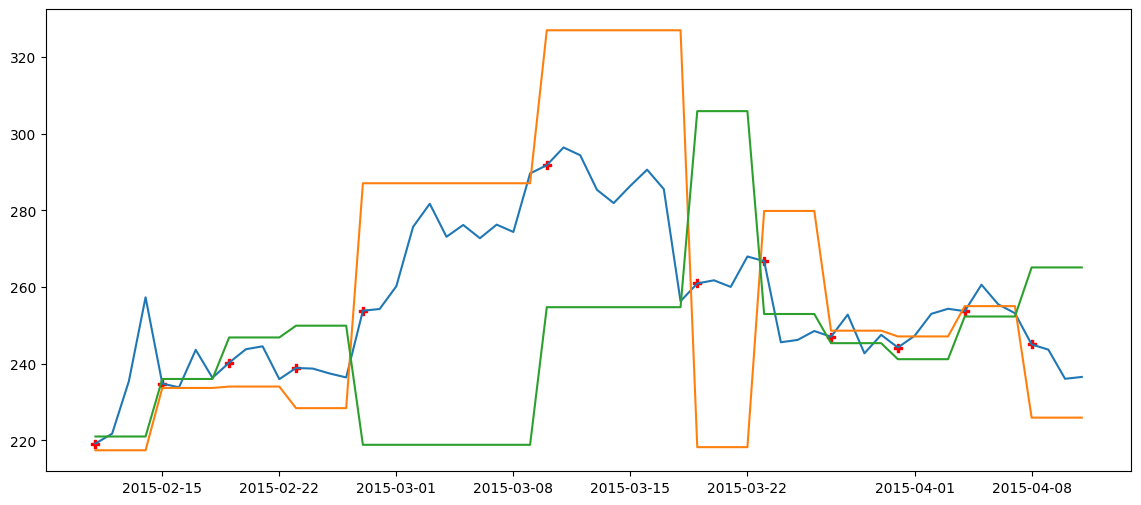

In [45]:
plot_df = tbl_df[0:60]
# Create a new DataFrame where 'window_start' is True
window_starts = plot_df[plot_df['window_start']]

plt.subplots(figsize=(14, 6))

# Plot the 'close', 'upper_barrier', and 'lower_barrier' columns
plt.plot(plot_df.index, plot_df[['close', 'upper_barrier', 'lower_barrier']], ms=1)

# Add markers at the start of each window
plt.scatter(window_starts.index, window_starts['close'], color='red', marker="P")

plt.show()

In [46]:
def band_generator(labels):
    bands = [{'label': labels.iloc[0], 'from': labels.index[0]}]
    for l, i in enumerate(labels):
        if i == bands[-1]["label"]:
            pass
        else:
            bands[-1]["to"] = labels.index[l]
            # Check if l + 1 is within the range of the labels' indices
            if l + 1 < len(labels):
                bands.append({'label': i, 'from': labels.index[l + 1]})

    # Check if the last band has a 'to' field
    if 'to' not in bands[-1]:
        bands[-1]['to'] = labels.index[-1]

    return bands

In [47]:
def plot_labels(price_series, labels):
    """
    Plot price series with bullish and bearish areas.

    Parameters:
    - price_series: A pandas Series of prices.
    - labels: A pandas Series of labels (-1, 0, 1).
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    # Plot the price series
    ax1.plot(price_series.index, price_series.values, label='Price', color='blue')

    # Draw a box for each window
    for label in labels:
        # Shift "from" and "to" by half a day
        from_timestamp = label["from"] - DateOffset(hours=12)
        to_timestamp = label["to"] + DateOffset(hours=12)

        # Ensure the timestamps are within the price series index
        from_timestamp = max(from_timestamp, price_series.index[0])
        to_timestamp = min(to_timestamp, price_series.index[-1])

        # Add the band
        ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color='green' if label["label"] == 2 else "red" if label["label"] == 0 else 'white' , alpha=0.3)

    # Add a legend
    ax1.legend()

    # Show the plot
    plt.show()

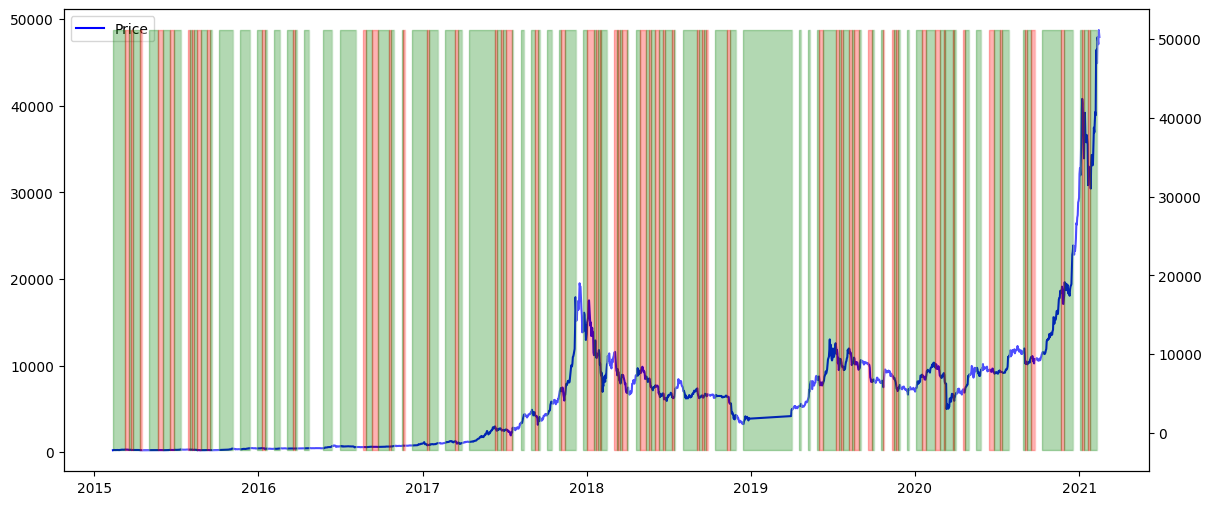

In [48]:
prices = tbl_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

In [49]:
price_df

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,returns,event
timestamp,,,,,,,,,,,
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1.000000,-0.004202,0.008337,NaN,False
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1.000000,0.008756,0.012383,0.011766,False
2015-02-13,221.968994,240.259003,221.261993,235.427002,42744400,1.562500,1.000000,0.074102,0.040530,0.061611,False
2015-02-14,235.528000,259.808014,235.528000,257.321014,49732500,0.930233,1.000000,0.160337,0.074090,0.092997,True
2015-02-15,257.506989,265.610992,227.684006,234.824997,56552400,0.360000,1.000000,-0.002557,0.069003,-0.087424,False
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587,0.030727,0.067779,0.066591,False
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950,0.057586,0.067252,-0.008443,False
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,0.975962,-0.016778,0.066857,-0.008406,False


In [50]:
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,returns,event,labels,window_start,upper_barrier,lower_barrier
timestamp,,,,,,,,,,,,,,,
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1.000000,-0.004202,0.008337,NaN,False,2,True,217.434878,221.027229
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1.000000,0.008756,0.012383,0.011766,False,2,False,217.434878,221.027229
2015-02-13,221.968994,240.259003,221.261993,235.427002,42744400,1.562500,1.000000,0.074102,0.040530,0.061611,False,2,False,217.434878,221.027229
2015-02-14,235.528000,259.808014,235.528000,257.321014,49732500,0.930233,1.000000,0.160337,0.074090,0.092997,True,2,False,217.434878,221.027229
2015-02-15,257.506989,265.610992,227.684006,234.824997,56552400,0.360000,1.000000,-0.002557,0.069003,-0.087424,False,2,True,233.684112,236.025928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587,0.030727,0.067779,0.066591,False,1,False,63683.043409,28373.802373
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950,0.057586,0.067252,-0.008443,False,1,False,63683.043409,28373.802373
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,0.975962,-0.016778,0.066857,-0.008406,False,1,False,63683.043409,28373.802373


### Calculate Engineered Features

In [51]:
# Calculate average duration of trends
def calculate_average_duration(df):
    current_label = df['labels'].iloc[0]
    duration_sum = 0
    trend_count = 0
    trend_start = df.index[0]
    for i in range(1, len(df)):
        if df['labels'].iloc[i] != current_label:
            duration_sum += (df.index[i] - trend_start).days
            trend_count += 1
            trend_start = df.index[i]
            current_label = df['labels'].iloc[i]
    average_duration = duration_sum / trend_count if trend_count > 0 else 0
    return average_duration

In [52]:
average_duration = calculate_average_duration(prices)
average_duration

11.972677595628415

In [53]:
average_duration = int(average_duration)
average_duration

11

In [54]:
def run_over_trend(df, avg_duration):
    df['run_over_trend'] = 0.0
    window_size = pd.Timedelta(days=avg_duration)

    # Iterate through the dataset in windows of `avg_duration`
    start_date = df.index[0]
    while start_date <= df.index[-1]:
        end_date = start_date + window_size

        # Extract the current window
        window = df[start_date:end_date]

        # Check if the window is empty
        if window.empty:
            # Move to the next window
            start_date = end_date
            continue

        trend_length = (window.index[-1] - window.index[0]).days

        if trend_length == 0:
          # Move to the next window
          start_date = end_date
          continue

        for i, date in enumerate(window.index):
            run_position = (date - window.index[0]).days + 1
            df.loc[date, 'run_over_trend'] = run_position / trend_length

        # Move to the next window
        start_date = end_date

    return df

In [55]:
def rise_over_trend(df, avg_duration):
    # Calculate average percentage change across all trend windows
    trend_changes = []
    window_size = pd.Timedelta(days=avg_duration)

    start_date = df.index[0]
    while start_date <= df.index[-1]:
        end_date = start_date + window_size
        window = df[start_date:end_date]

        if len(window) < 2:
            start_date = end_date
            continue

        start_price = window['close'].iloc[0]
        end_price = window['close'].iloc[-1]
        percentage_change = ((end_price - start_price) / start_price) * 100
        trend_changes.append(percentage_change)

        start_date = end_date

    average_change = sum(trend_changes) / len(trend_changes) if trend_changes else 0

    # Calculate rise_over_trend for each data point
    df['rise_over_trend'] = 0.0
    start_date = df.index[0]

    while start_date <= df.index[-1]:
        end_date = start_date + window_size
        window = df[start_date:end_date]

        if len(window) < 2:
            start_date = end_date
            continue

        start_price = window['close'].iloc[0]
        for date in window.index:
            current_price = window.loc[date, 'close']
            percentage_change = ((current_price - start_price) / start_price) * 100
            df.loc[date, 'rise_over_trend'] = percentage_change / average_change if average_change != 0 else 0

        start_date = end_date

    return df


In [56]:
def previous_window_trend(df, avg_duration):
    df['previous_window_trend'] = 0
    window_size = pd.Timedelta(days=avg_duration)
    previous_label = None

    start_date = df.index[0]

    while start_date <= df.index[-1]:
        end_date = start_date + window_size
        window = df[start_date:end_date]

        if previous_label is not None:
            df.loc[start_date:end_date, 'previous_window_trend'] = previous_label

        if not window.empty:
            previous_label = window['labels'].iloc[-1]

        start_date = end_date

    return df


In [57]:
prices = run_over_trend(prices, average_duration)
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,returns,event,labels,window_start,upper_barrier,lower_barrier,run_over_trend
timestamp,,,,,,,,,,,,,,,,
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1.000000,-0.004202,0.008337,NaN,False,2,True,217.434878,221.027229,0.090909
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1.000000,0.008756,0.012383,0.011766,False,2,False,217.434878,221.027229,0.181818
2015-02-13,221.968994,240.259003,221.261993,235.427002,42744400,1.562500,1.000000,0.074102,0.040530,0.061611,False,2,False,217.434878,221.027229,0.272727
2015-02-14,235.528000,259.808014,235.528000,257.321014,49732500,0.930233,1.000000,0.160337,0.074090,0.092997,True,2,False,217.434878,221.027229,0.363636
2015-02-15,257.506989,265.610992,227.684006,234.824997,56552400,0.360000,1.000000,-0.002557,0.069003,-0.087424,False,2,True,233.684112,236.025928,0.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587,0.030727,0.067779,0.066591,False,1,False,63683.043409,28373.802373,0.571429
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950,0.057586,0.067252,-0.008443,False,1,False,63683.043409,28373.802373,0.714286
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,0.975962,-0.016778,0.066857,-0.008406,False,1,False,63683.043409,28373.802373,0.857143


In [58]:
prices = rise_over_trend(prices, average_duration)
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,returns,event,labels,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend
timestamp,,,,,,,,,,,,,,,,,
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1.000000,-0.004202,0.008337,NaN,False,2,True,217.434878,221.027229,0.090909,0.000000
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1.000000,0.008756,0.012383,0.011766,False,2,False,217.434878,221.027229,0.181818,0.311616
2015-02-13,221.968994,240.259003,221.261993,235.427002,42744400,1.562500,1.000000,0.074102,0.040530,0.061611,False,2,False,217.434878,221.027229,0.272727,1.962487
2015-02-14,235.528000,259.808014,235.528000,257.321014,49732500,0.930233,1.000000,0.160337,0.074090,0.092997,True,2,False,217.434878,221.027229,0.363636,4.607895
2015-02-15,257.506989,265.610992,227.684006,234.824997,56552400,0.360000,1.000000,-0.002557,0.069003,-0.087424,False,2,True,233.684112,236.025928,0.454545,1.889748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587,0.030727,0.067779,0.066591,False,1,False,63683.043409,28373.802373,0.571429,0.981958
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950,0.057586,0.067252,-0.008443,False,1,False,63683.043409,28373.802373,0.714286,0.750076
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,0.975962,-0.016778,0.066857,-0.008406,False,1,False,63683.043409,28373.802373,0.857143,0.521144


In [59]:
prices = previous_window_trend(prices, average_duration)
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,returns,event,labels,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend,previous_window_trend
timestamp,,,,,,,,,,,,,,,,,,
2015-02-11,219.731995,223.406006,218.074005,219.184998,17201900,0.439394,1.000000,-0.004202,0.008337,NaN,False,2,True,217.434878,221.027229,0.090909,0.000000,0
2015-02-12,219.207993,222.199005,217.613998,221.764008,15206200,1.483871,1.000000,0.008756,0.012383,0.011766,False,2,False,217.434878,221.027229,0.181818,0.311616,0
2015-02-13,221.968994,240.259003,221.261993,235.427002,42744400,1.562500,1.000000,0.074102,0.040530,0.061611,False,2,False,217.434878,221.027229,0.272727,1.962487,0
2015-02-14,235.528000,259.808014,235.528000,257.321014,49732500,0.930233,1.000000,0.160337,0.074090,0.092997,True,2,False,217.434878,221.027229,0.363636,4.607895,0
2015-02-15,257.506989,265.610992,227.684006,234.824997,56552400,0.360000,1.000000,-0.002557,0.069003,-0.087424,False,2,True,233.684112,236.025928,0.454545,1.889748,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587,0.030727,0.067779,0.066591,False,1,False,63683.043409,28373.802373,0.571429,0.981958,2
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950,0.057586,0.067252,-0.008443,False,1,False,63683.043409,28373.802373,0.714286,0.750076,2
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,1.390805,0.975962,-0.016778,0.066857,-0.008406,False,1,False,63683.043409,28373.802373,0.857143,0.521144,2


## LSTM Model for Label Prediction

In [60]:
# Calculate ROC (Rate of Change)
prices['ROC'] = prices['close'].pct_change()

In [61]:
# Calculate RSI
rsi_period = average_duration  # You can choose an appropriate period
rsi_indicator = RSIIndicator(close=prices['close'], window=rsi_period)
prices['RSI'] = rsi_indicator.rsi()

In [62]:
# Calculate Momentum
momentum_period = average_duration  # You can choose an appropriate period
prices['Momentum'] = prices['close'].diff(periods=momentum_period)

In [63]:
# Create lag features
for lag in range(1, 4):  # Lag of 1, 2, and 3 days
    prices[f'close_lag_{lag}'] = prices['close'].shift(lag)

In [64]:
# Create rolling statistics
rolling_window = 5  # You can adjust this value

prices['rolling_mean'] = prices['close'].rolling(window=rolling_window).mean()
prices['rolling_std'] = prices['close'].rolling(window=rolling_window).std()

In [65]:
# Shift labels to create y_true
prices['y_true'] = prices['labels'].shift(-1)

# Drop the last row as it will have NaN for y_true
prices = prices[:-1]

# Convert y_true values to integers
prices['y_true'] = prices['y_true'].astype(int)

<ipython-input-65-f364e2553f68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['y_true'] = prices['y_true'].astype(int)


In [66]:
prices = prices.dropna()
prices

,open,high,low,close,volume,sentiment_ratio,impact_ratio,daily_returns,volatility,returns,...,previous_window_trend,ROC,RSI,Momentum,close_lag_1,close_lag_2,close_lag_3,rolling_mean,rolling_std,y_true
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-02-22,244.544006,246.391998,233.850998,235.977005,19527000,1.342857,1.000000,-0.032004,0.058066,-0.034993,...,2,-0.034993,53.606780,16.792007,244.533997,243.779007,240.283005,240.179803,4.013702,2
2015-02-23,235.994995,240.108994,232.421005,238.891998,16400000,0.488889,1.000000,-0.023072,0.056443,0.012353,...,2,0.012353,56.151746,17.127991,235.977005,244.533997,243.779007,240.693002,3.533023,2
2015-02-24,238.998001,239.901001,236.401993,238.735001,14200400,0.960000,1.000000,0.011688,0.054108,-0.000657,...,2,-0.000657,55.969847,3.307999,238.891998,235.977005,244.533997,240.383401,3.644016,2
2015-02-25,238.889999,239.339996,235.529999,237.470001,11496200,1.939394,1.010309,-0.005952,0.052184,-0.005299,...,2,-0.005299,54.407718,-19.851013,238.735001,238.891998,235.977005,239.121600,3.244706,2
2015-02-26,237.337006,237.710007,234.257004,236.425995,13619400,1.785714,1.000000,-0.009672,0.050503,-0.004396,...,2,-0.004396,53.063215,1.600998,237.470001,238.735001,238.891998,237.500000,1.316889,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-10,46469.761719,47145.566406,43881.152344,44918.183594,87301089896,1.630952,0.995475,-0.027671,0.068457,-0.033625,...,2,-0.033625,71.879099,10648.660156,46481.105469,46196.464844,38903.441406,43153.041406,3762.388321,1
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,1.319149,1.004587,0.030727,0.067779,0.066591,...,2,0.066591,76.337907,14794.972656,44918.183594,46481.105469,46196.464844,44881.705469,3506.927681,1
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,1.351064,0.990950,0.057586,0.067252,-0.008443,...,2,-0.008443,74.578939,13967.675781,47909.332031,44918.183594,46481.105469,46601.987500,1176.708324,1


In [67]:
# Feature
features = [
            'sentiment_ratio',
            'ROC',
            'RSI',
            'Momentum',
            # 'run_over_trend',
            'impact_ratio',
            'rise_over_trend',
            'previous_window_trend',
            # 'close_lag_1',
            # 'close_lag_2',
            # 'close_lag_3',
            # 'rolling_mean',
            # 'rolling_std'
            ]

In [68]:
# Labels
labels = prices['y_true']

# Normalize the feature data
scaler = StandardScaler()
prices[features] = scaler.fit_transform(prices[features])

In [69]:
# Define the window length
window_length = average_duration

# Create a function to generate overlapping windows
def create_windows_with_timestamps(df, window_length):
    windows = []
    labels = []
    timestamps = []

    for start in range(len(df) - window_length + 1):
        window = df.iloc[start:start + window_length]
        if window.isnull().values.any():  # Skip windows with missing values
            continue
        windows.append(window[features].values)
        labels.append(window['y_true'].values[-1])  # Use the last day's label as the window label
        timestamps.append(window.index)  # Save timestamps for each window

    return np.array(windows), np.array(labels), np.array(timestamps)


In [70]:
# Augment the data by creating overlapping windows
X_augmented, y_augmented, timestamps_augmented = create_windows_with_timestamps(prices, window_length)

In [71]:
len(X_augmented), X_augmented[0], len(X_augmented[0])

(2076,
 array([[-0.25579018, -0.98280335, -0.10638887, -0.13362016, -0.02205553,
         -0.17295287,  0.87535665],
        [-0.90484948,  0.23321522,  0.05485826, -0.13340923, -0.02205553,
         -0.03814676,  0.87535665],
        [-0.54678108, -0.1009313 ,  0.04333329, -0.14208521, -0.02205553,
         -0.04540724,  0.87535665],
        [ 0.19760812, -0.22014396, -0.05564205, -0.15662408, -0.00352278,
         -0.10390811,  0.87535665],
        [ 0.08080377, -0.19696729, -0.14082878, -0.14315684, -0.02205553,
         -0.15218899,  0.87535665],
        [-0.19969119,  1.80638276,  0.7864693 , -0.13161564, -0.02205553,
          0.65258026,  0.87535665],
        [-0.65888858, -0.04003678,  0.80386723, -0.13747413, -0.228685  ,
          0.67269705,  0.87535665],
        [-0.16168864,  0.51585962,  1.03360202, -0.12917294,  0.36663126,
          0.94735046,  0.87535665],
        [-0.88895299,  1.44274598,  1.47431422, -0.1219465 ,  0.72503077,
          1.66268083,  0.87535665],
   

In [72]:
# Shuffle the windows while keeping days in each window together
indices = np.arange(X_augmented.shape[0])
np.random.shuffle(indices)
X_augmented = X_augmented[indices]
y_augmented = y_augmented[indices]
timestamps_augmented = timestamps_augmented[indices]

# Convert the augmented data back into DataFrames for inspection
augmented_data_frames = []
for i in range(len(X_augmented)):
    window_df = pd.DataFrame(X_augmented[i], columns=features, index=timestamps_augmented[i])
    window_df['y_true'] = y_augmented[i]
    augmented_data_frames.append(window_df)

# Combine all augmented windows into a single DataFrame
augmented_df = pd.concat(augmented_data_frames)

In [73]:
augmented_df

,sentiment_ratio,ROC,RSI,Momentum,impact_ratio,rise_over_trend,previous_window_trend,y_true
2018-03-16,0.716592,0.031943,-1.351721,-2.175013,-1.764588,-1.340733,0.875357,0
2018-03-17,1.556487,-1.382259,-1.563591,-1.941522,1.637338,-1.833312,0.875357,0
2018-03-18,0.131072,0.911258,-1.242200,-1.237694,1.437097,-1.474750,0.875357,0
2018-03-19,0.331370,1.186974,-0.849417,-0.624015,1.764524,-0.999117,0.875357,0
2018-03-20,0.243672,0.757582,-0.596719,-0.410393,1.154605,-0.172953,-1.790328,0
...,...,...,...,...,...,...,...,...
2018-04-15,-0.129913,1.018616,0.528350,0.781990,1.423373,1.958152,-0.457486,2
2018-04-16,0.507363,-0.917984,0.153449,0.638811,1.106973,1.534621,-0.457486,2
2018-04-17,0.638898,-0.583087,-0.051003,0.650469,0.958495,1.289405,-0.457486,2
2018-04-18,-0.195733,0.765334,0.217504,0.642031,1.265313,1.698668,-0.457486,2


In [74]:
augmented_df['y_true'].value_counts()

,count
y_true,
2,11341
1,7304
0,4191


In [75]:
# Labels
labels = augmented_df['y_true']

# Normalize the feature data
scaler = StandardScaler()
augmented_df[features] = scaler.fit_transform(augmented_df[features])

In [76]:
# Splitting the dataset into train and test sets without shuffling
X_train, X_test, y_train, y_test = train_test_split(augmented_df[features].values, labels.values, test_size=0.2, shuffle=False)

In [77]:
X_train.shape

(18268, 7)

In [78]:
# Reshape the data to fit into LSTM (samples, timesteps, features)
# Assuming each input is treated as a separate timestep in a single sequence
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [79]:
X_train.shape

(18268, 1, 7)

In [80]:
# Balance the dataset using oversampling
train_data = np.hstack((X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train.reshape(-1, 1)))
train_df = pd.DataFrame(train_data, columns=features + ['y_true'])

# Separate classes
class_0 = train_df[train_df['y_true'] == 0]
class_1 = train_df[train_df['y_true'] == 1]
class_2 = train_df[train_df['y_true'] == 2]

# Resample minority classes
# class_1_over = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
# class_2_over = resample(class_2, replace=True, n_samples=len(class_0), random_state=42)

# Combine to create balanced dataset
# balanced_train_df = pd.concat([class_0, class_1_over, class_2_over])
balanced_train_df = pd.concat([class_0, class_1, class_2])
# balanced_train_df = train_df

In [81]:
# Convert y_true values to integers
balanced_train_df['y_true'] = balanced_train_df['y_true'].astype(int)
balanced_train_df

,sentiment_ratio,ROC,RSI,Momentum,impact_ratio,rise_over_trend,previous_window_trend,y_true
0,0.714839,0.033356,-1.347894,-2.310750,-1.760474,-1.337562,0.879086,0
1,1.553396,-1.382256,-1.559705,-2.060703,1.633444,-1.829342,0.879086,0
2,0.130251,0.913547,-1.238403,-1.306972,1.433675,-1.471361,0.879086,0
3,0.330230,1.189538,-0.845730,-0.649782,1.760331,-0.996500,0.879086,0
4,0.242672,0.759717,-0.593102,-0.421013,1.151848,-0.171675,-1.785123,0
...,...,...,...,...,...,...,...,...
18233,-0.305379,-0.513156,-1.198997,-0.140943,0.021699,-0.319028,-1.785123,2
18234,-0.937746,0.096097,-0.934337,-0.135438,1.523079,-0.244258,-1.785123,2
18235,-0.715863,-0.074020,-0.921006,-0.136048,1.472494,-0.240581,-1.785123,2
18236,-0.082545,0.069322,-0.682668,-0.134647,1.671766,-0.176540,-1.785123,2


In [82]:
balanced_train_df['y_true'].value_counts()

,count
y_true,
2,9064
1,5940
0,3264


In [83]:
# Extract features and labels after balancing
X_train_balanced = balanced_train_df[features].values.reshape(-1, 1, len(features))
y_train_balanced = balanced_train_df['y_true'].values

# Convert labels to categorical for multi-class classification
y_train_balanced = to_categorical(y_train_balanced, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [84]:
X_train.shape

(18268, 1, 7)

In [85]:
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [101]:
# LSTM Model with increased capacity
model = Sequential()

# First LSTM layer with increased units and return_sequences=True for stacking
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

# Second LSTM layer with increased units and return_sequences=True for stacking
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer with return_sequences=False for final output
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Dense layer for additional capacity
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))

# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model with a slightly reduced learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0015),
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [102]:
neptune_callback = NeptuneCallback(
    run=run,
    base_namespace='training with a more complicated LSTM model.',
    log_on_batch=True,
    log_model_diagram=False,  # Requires pydot to be installed
)

In [103]:
# Train the model with early stopping
history = model.fit(X_train_balanced, y_train_balanced,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[neptune_callback]
                    )

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4956 - loss: 1.0795 - val_accuracy: 0.5134 - val_loss: 1.0084
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5261 - loss: 0.9972 - val_accuracy: 0.5315 - val_loss: 0.9958
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5445 - loss: 0.9795 - val_accuracy: 0.5225 - val_loss: 0.9851
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5511 - loss: 0.9656 - val_accuracy: 0.5436 - val_loss: 0.9585
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5619 - loss: 0.9500 - val_accuracy: 0.5519 - val_loss: 0.9521
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5692 - loss: 0.9301 - val_accuracy: 0.5565 - val_loss: 0.9375
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5775 - loss: 0.9175 - val_accuracy: 0.5665 - val_loss: 0.9220
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5861 - loss: 0.903

In [104]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7088


In [105]:
# Log final evaluation metrics to Neptune
run["evaluation/test_loss"] = loss
run["evaluation/test_accuracy"] = accuracy

In [106]:
# Model Evaluation Metrics
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [107]:
# Display the first few predictions
print(f"Predictions: {y_pred_classes[:15]}")
print(f"Actual Labels: {y_true_classes[:15]}")

Predictions: [2 2 0 2 2 2 2 1 2 1 1 1 1 1 2]
Actual Labels: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 2]


In [108]:
y_pred_classes

array([2, 2, 0, ..., 2, 2, 2])

In [109]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

Accuracy: 0.7088441330998249
F1 Score: 0.703961461564028
Recall: 0.7088441330998249
Precision: 0.7013619318122519


In [110]:
# Log additional metrics to Neptune
run["evaluation/accuracy"] = accuracy
run["evaluation/f1_score"] = f1
run["evaluation/recall"] = recall
run["evaluation/precision"] = precision

# Stop the Neptune run
run.stop()

In [111]:
print(classification_report(y_true_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.5310    0.4434    0.4832       927
           1     0.7669    0.8226    0.7938      1364
           2     0.7314    0.7488    0.7400      2277

    accuracy                         0.7088      4568
   macro avg     0.6765    0.6716    0.6723      4568
weighted avg     0.7014    0.7088    0.7040      4568



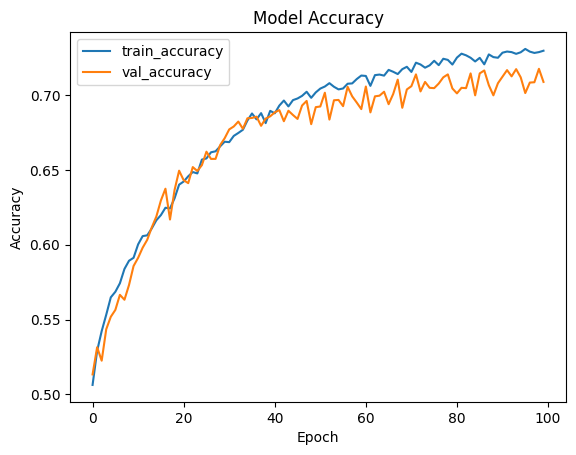

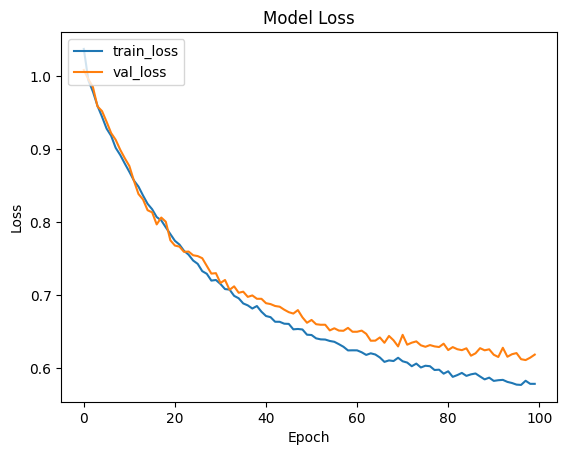

In [112]:
# Optionally, you can plot the training history to check the training process
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

                       sentiment_ratio       ROC       RSI  Momentum  \
sentiment_ratio               1.000000 -0.021747 -0.020124  0.044598   
ROC                          -0.021747  1.000000  0.379765  0.230301   
RSI                          -0.020124  0.379765  1.000000  0.519731   
Momentum                      0.044598  0.230301  0.519731  1.000000   
impact_ratio                  0.062394  0.272140  0.192956  0.061985   
rise_over_trend              -0.022270  0.401800  0.659654  0.419414   
previous_window_trend        -0.008736  0.074175  0.223038  0.104411   
y_true                       -0.044439  0.083112  0.047959 -0.048363   

                       impact_ratio  rise_over_trend  previous_window_trend  \
sentiment_ratio            0.062394        -0.022270              -0.008736   
ROC                        0.272140         0.401800               0.074175   
RSI                        0.192956         0.659654               0.223038   
Momentum                   0.061985

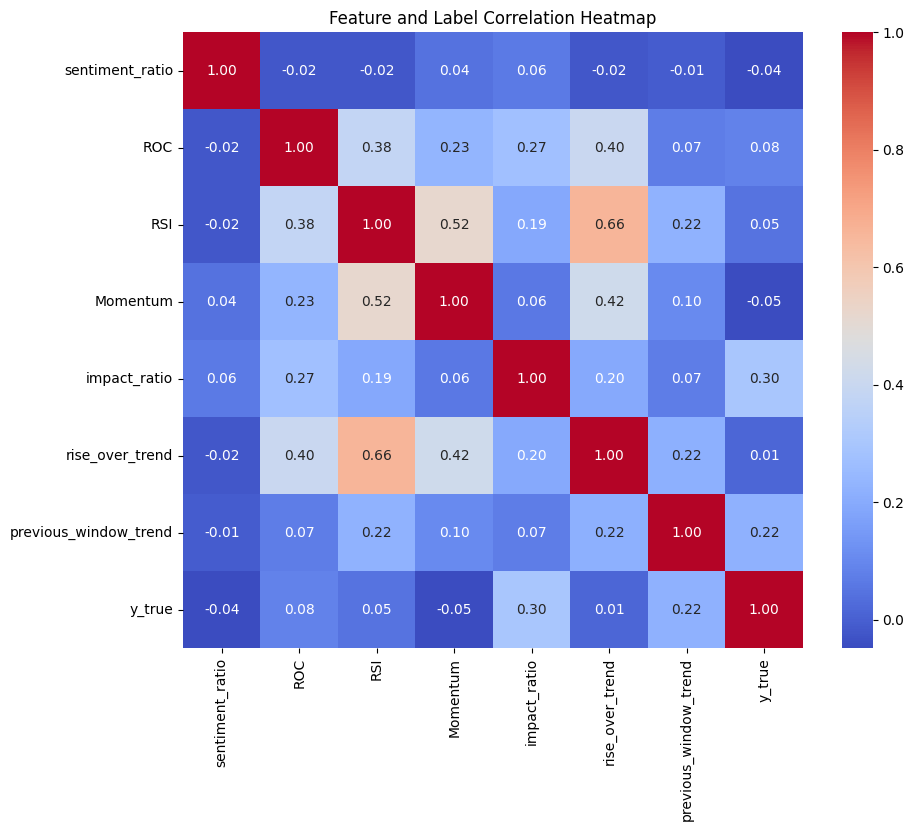

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix including the y_true
correlation_matrix_with_label = prices[features + ['y_true']].corr()

# Display the correlation matrix
print(correlation_matrix_with_label)

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_with_label, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Feature and Label Correlation Heatmap')
plt.show()

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


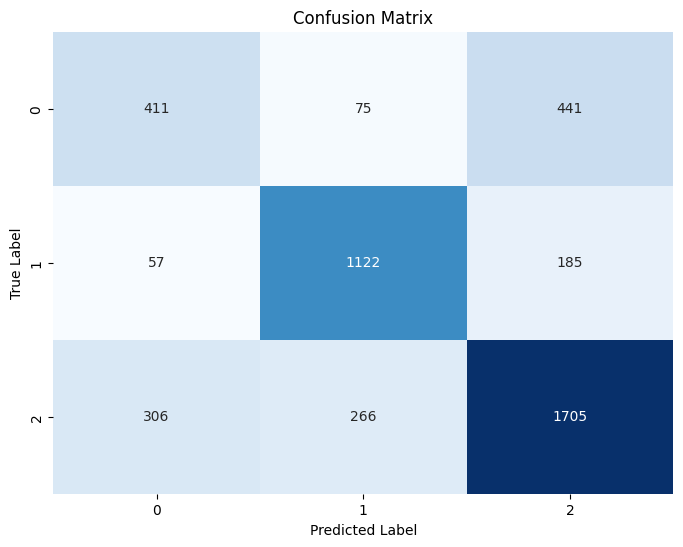

In [114]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoding to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
